In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import timeit
np.random.seed(2)
# ******************** LOAD_DATA from sklearn *********************
from sklearn.datasets import load_digits
digits_x, digits_y = load_digits(return_X_y=True)
digits_y = digits_y.astype(int)
print(digits_x.shape, digits_y.shape)
print(np.unique(digits_y))

(1797, 64) (1797,)
[0 1 2 3 4 5 6 7 8 9]


In [ ]:
#*****************Load dataset from OpenML（balance-scale)*******************
bs_x,y = fetch_openml('balance-scale', version=1, return_X_y=True)
print(bs_x.shape)
print(np.unique(y))
#change label to int
def change_to_int(t):
  if t=='B':
    return 0
  if t=='L':
    return 1
  if t=='R':
    return 2

bs_y = np.array([change_to_int(t) for t in y])
print(np.unique(bs_y))

(625, 4)
['B' 'L' 'R']
[0 1 2]


# Softmax Regression

In [ ]:
def softmax(z):
    """ applies softmax to an input x"""
    return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

def one_hot_encoding(arr,k):
    onehot_encoded = list()
    for value in arr:
        letter=np.zeros(k)
        letter[value]=1
        onehot_encoded.append(letter)
    return onehot_encoded

In [ ]:
# ******************** Softmax regression *********************
class SoftmaxRegression:
    def __init__(self, num_of_cols, add_bias =True,l2_regularization=0.1):
        self.w = None
        self.add_bias = add_bias
        self.num_of_cols = num_of_cols
        self.l2_regularization=l2_regularization
        pass
    def fit(self,X_train,y_train,X_test,y_test,optimizer):
        if self.add_bias:
            N = X_train.shape[0]
            X_train = np.column_stack([X_train, np.ones(N)])
            N2=X_test.shape[0]
            X_test=np.column_stack([X_test,np.ones(N2)])
        N,D = X_train.shape
        def gradient(x,y,w):
            yh=softmax(x@w)
            grad = (x.T @ (yh - one_hot_encoding(y, self.num_of_cols)))/N
            #with self.addbaised
            if self.add_bias:
              #implement regularization without panalizating bias weight
              grad[:-1] = grad[:-1]+ w[:-1] * self.l2_regularization
            else:
              grad=grad+w*self.l2_regularization
            return grad
        w0 = np.zeros((D, self.num_of_cols))    
        self.w,number_of_iterations,training_history,validation_history=optimizer.run(gradient,X_train,y_train,X_test,y_test,w0,self.num_of_cols) 
        #self.w,record= optimizer.run(gradient,X_train,y_train,X_test,y_test,w0,self.num_of_cols)
        return number_of_iterations,training_history,validation_history
        #return record
    def predict(self,x):
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x, np.ones(N)])
        yh=softmax(x@self.w)
        return yh

In [ ]:
# ******************** GradientDescent with minibatches *********************
class GradientDescent:
  def __init__(self, learning_rate=.01, batch_size=256,beta=0.9,termination=20,l2_regularization=0.1,max_iters=1e4, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.termination=termination
        self.batch_size=batch_size
        self.beta=beta
        self.l2_regularization=l2_regularization
        self.epsilon = epsilon
        self.max_iters = max_iters

        #self.w_history = []                 #to store the weight history for visualization
            
  #create list containing mini-batches
  def create_mini_batches(self, x, y, batch_size):
        assert x.shape[0] == y.shape[0]
        indices = np.arange(x.shape[0])
        np.random.shuffle(indices)
        minibatches=[]
        for start_idx in range(0, x.shape[0], batch_size):
          end_idx = min(start_idx + batch_size, x.shape[0])
          minibatch_x=x[start_idx:end_idx,:]
          minibatch_y=y[start_idx:end_idx]
          minibatches.append((minibatch_x,minibatch_y))
        
        return minibatches


  def accuracy(self,x,y,w):
        y_pred=np.argmax(softmax(x@w),axis=1)
        
        return sum(y_pred == y)/(float(len(y)))
  
  #perform mini-batch gradient descent
  def run(self, gradient_fn, x_train, y_train, x_val, y_val, w, k):
        grad = np.inf
        delta_w=0
        best_w=w.copy()
        best_acc=0
        t = 0
        step=0
        stop=False
        training_history=[]
        validation_history=[]
        val_last=0
        number_of_iterations=0

        while (stop==False) :
          miniba=self.create_mini_batches(x_train,y_train,self.batch_size)
          for minib in miniba:
            (x,y)=minib
            grad = gradient_fn(x, y, w)               # compute the gradient with present weight
            delta_w=self.beta*delta_w+(1-self.beta)*grad   # weight update step
            w=w-self.learning_rate*delta_w
            
            train_accuracy=self.accuracy(x,y,w)
            training_history.append(train_accuracy)
            val_accuracy=self.accuracy(x_val,y_val,w)
            val_accuracy = round(val_accuracy, 5)
            validation_history.append(val_accuracy)
            
            #self.w_history.append(w)
            if best_acc<val_accuracy:
              best_acc=val_accuracy
              best_w=w.copy()
              step=0
            
            else:
              step=step+1
              if step>=self.termination:
                stop=True
                number_of_iterations=t
                break

            t += 1
        return best_w,number_of_iterations,training_history,validation_history       


In [ ]:
def run_k_fold_cross_val(x, y, model, optimizer,folds=5):
    arr=np.arange(len(x))
    np.random.shuffle(arr)
    lst = np.array_split(arr, folds)
    train_his=[]
    valid_his=[]
    time=[]
    for i in range(folds):
        train_his.append([])
        valid_his.append([])
        train=[]
        train.extend(lst[:i])
        train.extend(lst[i+1:])
        val=lst[i] 
        flat_list = [item for sublist in train for item in sublist]
        x_train, y_train = x[flat_list], y[flat_list]
        x_val, y_val = x[val], y[val]
        #timer
        start = timeit.default_timer()
        number_of_iterations,training_history,validation_history = model.fit(x_train, y_train, x_val, y_val, optimizer)
        stop = timeit.default_timer()
        time.append(stop - start)

        train_his[i]=training_history
        valid_his[i]=validation_history

        history= model.fit(x_train, y_train, x_val, y_val, optimizer)
        #print(history)
        
        #print(number_of_iterations)
        #print(training_history)
        #print(validation_history)
    #print(time)
    return train_his,valid_his,time
        

## Visualizing Softmax regression for Digits dataset

In [ ]:
model = SoftmaxRegression(10)
optimizer = GradientDescent()
train_his,valid_his,time=run_k_fold_cross_val(digits_x, digits_y, model, optimizer)

In [ ]:
import plotly
import plotly.graph_objs as go

In [ ]:
def plotgraph(data,title,label_x,label_y):
  fig = go.Figure()
  for i in np.arange(len(data)):
    fig.add_trace(go.Scatter(x=np.arange(len(data[i])), y=data[i], name='run'+str(i+1),mode='lines'))
  fig.update_layout(title=title,xaxis_title=label_x,yaxis_title=label_y, autosize=False, width=800, height=300, margin=dict(l=50,r=50,b=30,t=30,pad=2))
  fig.show()

In [ ]:
plotgraph(train_his,'training accuracy for digits set(5-fold)','iteration','training accuracy')
plotgraph(valid_his,'validation accuracy for digits set(5-fold)','iteration','validation accuracy')

## Visualizing Softmax regression for OpenML(balanced-scale)

In [ ]:
model = SoftmaxRegression(3)
optimizer = GradientDescent()
train_his,valid_his,time=run_k_fold_cross_val(bs_x, bs_y, model, optimizer)

In [ ]:
plotgraph(train_his,'Training accuracy for OpenML(balance-scale)','Iteration','Training accuracy')
plotgraph(valid_his,'Validation accuracy for OpenMl(balance-scale)','Iteration','Validation accuracy')

# Visualizing Decision Tree

Visualizing Cross Validation Decision Tree for Digits dataset

The depth-15 tree achieves the best mean cross-validation accuracy 0.8619885484370166 on training dataset
The time it used is 0.04169026899980963


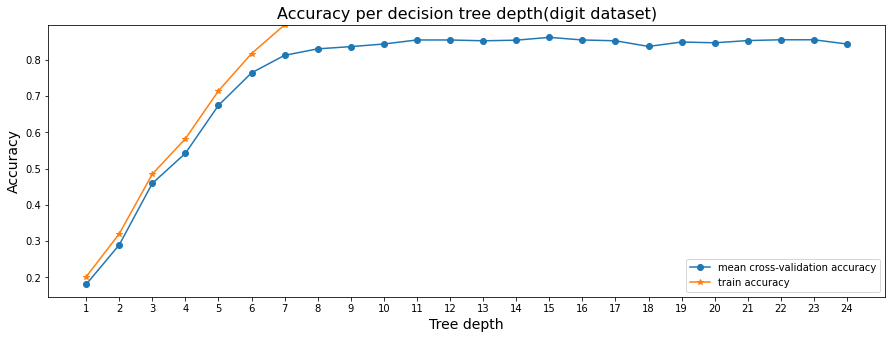

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
def k_fold_cross_val(x, k = 5):
    lst = list(range(len(x)))
    np.random.shuffle(lst)
    folds = np.array_split(lst, k)
    for i in range(k):
        test = np.concatenate(*[folds[:i] + folds[i+1:]])
        val = folds[i]
        yield test.flatten(), val

def DT_5_fold_cross_val(x, y, max):
    avg_val_accuracy = []
    val_accuracy = []
    train_acc_avg=[]
    time_all=[]
    for a in range(1, max):
        time=[]
        val_acc_row = []
        train_acc_row=[]
        tree = DecisionTreeClassifier(random_state=0, max_depth=a)
        for i, (train_id, val_id) in enumerate(k_fold_cross_val(x)):
            x_train, y_train = x[train_id], y[train_id]
            x_val, y_val = x[val_id], y[val_id]
            start=timeit.default_timer()
            tr_acc=tree.fit(x_train,y_train).score(x_train,y_train)
            accuracy=tree.fit(x_train, y_train).score(x_val, y_val)
            stop = timeit.default_timer()
            time.append(stop - start)
            val_acc_row.append(accuracy)
            train_acc_row.append(tr_acc)
        avg_acc = np.average(val_acc_row)
        avg_val_accuracy.append(avg_acc)
        val_accuracy.append(val_acc_row)
        train_acc_avg.append(np.mean(train_acc_row))
        time_all.append(np.mean(time))

    train_acc_avg=np.array(train_acc_avg)
    avg_val_accuracy = np.array(avg_val_accuracy)
    return train_acc_avg, avg_val_accuracy,time_all

# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, accuracy_scores,title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy')
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy')
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()



train_acc_avg, avg_val_accuracy,time_all = DT_5_fold_cross_val(digits_x, digits_y, 25)

depth=range(1,25)
# plotting accuracy
plot_cross_validation_on_trees(depth, avg_val_accuracy, train_acc_avg, 'Accuracy per decision tree depth(digit dataset)')

idx_max = avg_val_accuracy.argmax()
best_tree_depth = depth[idx_max]
best_tree_cv_score = avg_val_accuracy[idx_max]
print('The depth-{} tree achieves the best mean cross-validation accuracy {} on training dataset'.format(
      best_tree_depth,best_tree_cv_score ))
print('The time it used is {}'.format(time_all[idx_max]))

visualizing Cross Validation Decision Tree for OpenML(Balanced scale)

The depth-6 tree achieves the best mean cross-validation accuracy 0.8 on training dataset
The time it used is 0.0022122774000308707


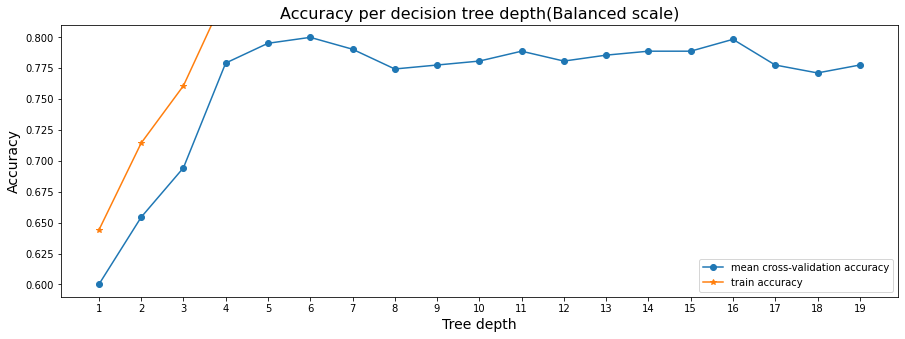

In [ ]:
train_acc_avg, avg_val_accuracy,time_all = DT_5_fold_cross_val(bs_x, bs_y, 20)

depth=range(1,20)
# plotting accuracy
plot_cross_validation_on_trees(depth, avg_val_accuracy, train_acc_avg, 'Accuracy per decision tree depth(Balanced scale)')

idx_max = avg_val_accuracy.argmax()
best_tree_depth = depth[idx_max]
best_tree_cv_score = avg_val_accuracy[idx_max]
print('The depth-{} tree achieves the best mean cross-validation accuracy {} on training dataset'.format(
      best_tree_depth,best_tree_cv_score ))
print('The time it used is {}'.format(time_all[idx_max]))

# Classifer compare: KNN 

The k-5 neighborhood achieves the best mean cross-validation accuracy 0.9888656762612195 on training dataset
The time it used is 0.3547696164001536


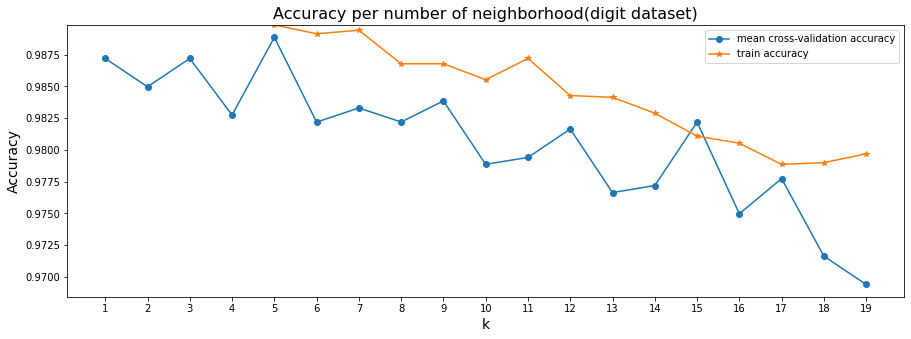

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
def k_fold_cross_val(x, k = 5):
    lst = list(range(len(x)))
    np.random.shuffle(lst)
    folds = np.array_split(lst, k)
    for i in range(k):
        test = np.concatenate(*[folds[:i] + folds[i+1:]])
        val = folds[i]
        yield test.flatten(), val

def knn_5_fold_cross_val(x, y, max):
    avg_val_accuracy = []
    val_accuracy = []
    train_acc_avg=[]
    time_all=[]
    for a in range(1, max):
        time=[]
        val_acc_row = []
        train_acc_row=[]
        KNN = KNeighborsClassifier(n_neighbors=a)
        for i, (train_id, val_id) in enumerate(k_fold_cross_val(x)):
            x_train, y_train = x[train_id], y[train_id]
            x_val, y_val = x[val_id], y[val_id]
            start=timeit.default_timer()
            tr_acc=KNN.fit(x_train,y_train).score(x_train,y_train)
            accuracy=KNN.fit(x_train, y_train).score(x_val, y_val)
            stop = timeit.default_timer()
            time.append(stop - start)
            val_acc_row.append(accuracy)
            train_acc_row.append(tr_acc)
        avg_acc = np.average(val_acc_row)
        avg_val_accuracy.append(avg_acc)
        val_accuracy.append(val_acc_row)
        train_acc_avg.append(np.mean(train_acc_row))
        time_all.append(np.mean(time))

    train_acc_avg=np.array(train_acc_avg)
    avg_val_accuracy = np.array(avg_val_accuracy)
    return train_acc_avg, avg_val_accuracy,time_all

# function for plotting cross-validation results
def plot_cross_validation_on_KNN(depths, cv_scores_mean, accuracy_scores,title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy')
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy')
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('k', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()


##digit dataset
train_acc_avg, avg_val_accuracy,time_all = knn_5_fold_cross_val(digits_x, digits_y, 20)

K=range(1,20)
# plotting accuracy
plot_cross_validation_on_KNN(K, avg_val_accuracy, train_acc_avg, 'Accuracy per number of neighborhood(digit dataset)')

idx_max = avg_val_accuracy.argmax()
best_tree_depth = depth[idx_max]
best_tree_cv_score = avg_val_accuracy[idx_max]
print('The k-{} neighborhood achieves the best mean cross-validation accuracy {} on training dataset'.format(
      best_tree_depth,best_tree_cv_score ))
print('The time it used is {}'.format(time_all[idx_max]))

The k-17 neighborhood achieves the best mean cross-validation accuracy 0.9007999999999999 on training dataset
The time it used is 0.022606412601453484


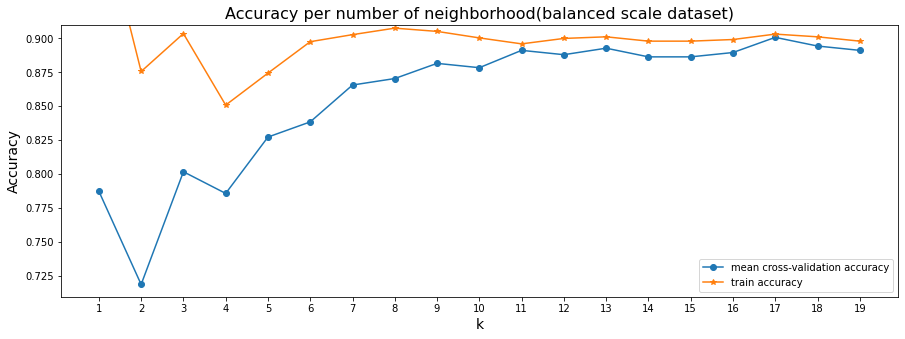

In [ ]:
train_acc_avg, avg_val_accuracy,time_all = knn_5_fold_cross_val(bs_x, bs_y, 20)

K=range(1,20)
# plotting accuracy
plot_cross_validation_on_KNN(K, avg_val_accuracy, train_acc_avg, 'Accuracy per number of neighborhood(balanced scale dataset)')

idx_max = avg_val_accuracy.argmax()
best_tree_depth = depth[idx_max]
best_tree_cv_score = avg_val_accuracy[idx_max]
print('The k-{} neighborhood achieves the best mean cross-validation accuracy {} on training dataset'.format(
      best_tree_depth,best_tree_cv_score ))
print('The time it used is {}'.format(time_all[idx_max]))

# Hyper-parameters of the optimization procedure

In [ ]:
def create_hyperparams_grid(x,y,model,batch_size,learning_rate,momentum,termination_step):
  graph_b=[]
  graph_l=[]
  graph_m=[]
  graph_t=[]
  graph_time=[]
  graph_time_avg=[]
  graph_train_acc=[]
  graph_val_acc=[]
  graph_train_acc_avg=[]
  graph_val_acc_avg=[]
  for bs in batch_size:
    graph_b_row=[]
    graph_l_row=[]
    graph_m_row=[]
    graph_t_row=[]
    graph_time_row=[]
    graph_time_avg_row=[]
    graph_train_acc_row=[]
    graph_val_acc_row=[]
    graph_train_acc_avg_row=[]
    graph_val_acc_avg_row=[]
    for lr in learning_rate:
      graph_b_row_row=[]
      graph_l_row_row=[]
      graph_m_row_row=[]
      graph_t_row_row=[]
      graph_time_row_row=[]
      graph_time_avg_row_row=[]
      graph_train_acc_row_row=[]
      graph_val_acc_row_row=[]
      graph_train_acc_avg_row_row=[]
      graph_val_acc_avg_row_row=[]
      for mom in momentum:
        graph_b_row_row_row=[]
        graph_l_row_row_row=[]
        graph_m_row_row_row=[]
        graph_t_row_row_row=[]
        graph_time_row_row_row=[]
        graph_time_avg_row_row_row=[]
        graph_train_acc_row_row_row=[]
        graph_val_acc_row_row_row=[]
        graph_train_acc_avg_row_row_row=[]
        graph_val_acc_avg_row_row_row=[]
        for ts in termination_step:
          optimizer = GradientDescent(batch_size=bs, learning_rate=lr, beta=mom,termination=ts)
          train_his,valid_his,time=run_k_fold_cross_val(x, y, model, optimizer)
          graph_time_row_row_row.append(time)
          graph_time_avg_row_row_row.append(np.mean(time))
          graph_train_acc_row_row_row.append(train_his)
          graph_val_acc_row_row_row.append(valid_his)
    
          #find average of max validation accuracy of 5 fold
          #find average of training accuracy of 5 fold corresponding to the weight of max validation accuracy 
          val_max=[]
          train_according=[]
          i=0
          for row in valid_his:
            ma=np.amax(row)
            val_max.append(ma)
            pos=np.where(row == ma)[0]
            tr=train_his[i][pos[0]]
            train_according.append(tr)
            i=i+1
           
          graph_val_acc_avg_row_row_row.append(np.mean(val_max))
           
          graph_train_acc_avg_row_row_row.append(np.mean(train_according))
          graph_b_row_row_row.append(bs)
          graph_l_row_row_row.append(lr)
          graph_m_row_row_row.append(mom)
          graph_t_row_row_row.append(ts)
        graph_b_row_row.append(graph_b_row_row_row)
        graph_l_row_row.append(graph_l_row_row_row)
        graph_m_row_row.append(graph_m_row_row_row)
        graph_t_row_row.append(graph_t_row_row_row)
        graph_time_row_row.append(graph_time_row_row_row)
        graph_time_avg_row_row.append(graph_time_avg_row_row_row)
        graph_train_acc_row_row.append(graph_train_acc_row_row_row)
        graph_val_acc_row_row.append(graph_val_acc_row_row_row)
        graph_train_acc_avg_row_row.append(graph_train_acc_avg_row_row_row)
        graph_val_acc_avg_row_row.append(graph_val_acc_avg_row_row_row)
      graph_b_row.append(graph_b_row_row)
      graph_l_row.append(graph_l_row_row)
      graph_m_row.append(graph_m_row_row)
      graph_t_row.append(graph_t_row_row)
      graph_time_row.append(graph_time_row_row)
      graph_time_avg_row.append(graph_time_avg_row_row)
      graph_train_acc_row.append(graph_train_acc_row_row)
      graph_val_acc_row.append(graph_val_acc_row_row)
      graph_train_acc_avg_row.append(graph_train_acc_avg_row_row)
      graph_val_acc_avg_row.append(graph_val_acc_avg_row_row)
    graph_b.append(graph_b_row)
    graph_l.append(graph_l_row)
    graph_m.append(graph_m_row)
    graph_t.append(graph_t_row)
    graph_time.append(graph_time_row)
    graph_time_avg.append(graph_time_avg_row)
    graph_train_acc.append(graph_train_acc_row)
    graph_val_acc.append(graph_val_acc_row)
    graph_train_acc_avg.append(graph_train_acc_avg_row)
    graph_val_acc_avg.append(graph_val_acc_avg_row)
  graph_b=np.array(graph_b)
  graph_l=np.array(graph_l)
  graph_m=np.array(graph_m)
  graph_t=np.array(graph_t)
  graph_time=np.array(graph_time)
  graph_time_avg=np.array(graph_time_avg)
  graph_train_acc=np.array(graph_train_acc)
  graph_val_acc=np.array(graph_val_acc)
  graph_train_acc_avg=np.array(graph_train_acc_avg)
  graph_val_acc_avg=np.array(graph_val_acc_avg)
  return graph_b,graph_l,graph_m,graph_t,graph_time,graph_time_avg,graph_train_acc,graph_val_acc,graph_train_acc_avg,graph_val_acc_avg






In [ ]:
def plot_grid_search(graph_b,graph_l,graph_m,graph_t,graph_time,graph_time_avg,graph_train_acc,graph_val_acc,graph_train_acc_avg,graph_val_acc_avg):
  max_z = np.max(graph_val_acc_avg)
  pos_z = np.argwhere(graph_val_acc_avg == max_z)[0]
  print('Hyperparameters for max validation accuracy:')
  print('validation accuracy: %.4f' %(max_z))
  print('batch size: %.2f' %(graph_b[pos_z[0],pos_z[1],pos_z[2],pos_z[3]]))
  print('learning rate: %.2f' %(graph_l[pos_z[0],pos_z[1],pos_z[2],pos_z[3]]))
  print('momentum: %.2f' %(graph_m[pos_z[0],pos_z[1],pos_z[2],pos_z[3]]))
  print('termination step: %.2f'%(graph_t[pos_z[0],pos_z[1],pos_z[2],pos_z[3]]))
  print('run time(second) for 5 folds are: ',graph_time[pos_z[0],pos_z[1],pos_z[2],pos_z[3]])
  print('mean run time(second) for 5 folds are: ',graph_time_avg[pos_z[0],pos_z[1],pos_z[2],pos_z[3]])
  plotgraph(graph_train_acc[pos_z[0],pos_z[1],pos_z[2],pos_z[3]], 'training accuracy with best hyperparameters','iteration','training accuracy')
  plotgraph(graph_val_acc[pos_z[0],pos_z[1],pos_z[2],pos_z[3]], 'validation accuracy with best hyperparameters','iteration','validation accuracy')


Grid search for digits dataset

In [ ]:
batch_size=[16,32,64,128,256,360,512]
learning_rate=[0.01,0.05,0.1,0.2]
momentum=[0.3,0.5,0.7,0.9]
termination_step=[20,40,60]
model = SoftmaxRegression(10)
graph_b,graph_l,graph_m,graph_t,graph_time,graph_time_avg,graph_train_acc,graph_val_acc,graph_train_acc_avg,graph_val_acc_avg = create_hyperparams_grid(digits_x, digits_y, model, batch_size,learning_rate,momentum,termination_step)
plot_grid_search(graph_b,graph_l,graph_m,graph_t,graph_time,graph_time_avg,graph_train_acc,graph_val_acc,graph_train_acc_avg,graph_val_acc_avg)

Hyperparameters for max validation accuracy:
validation accuracy: 0.9705
batch size: 512.00
learning rate: 0.20
momentum: 0.90
termination step: 60.00
run time(second) for 5 folds are:  [0.57668817 0.85876467 0.65603758 0.69594108 0.84119369]
mean run time(second) for 5 folds are:  0.7257250365997606


In [ ]:
def parameter_change(batch_size,learn_rate,momentum,termination_step,opt_bs,opt_lr,opt_mom,opt_ts,num_of_col,x,y):
  #batch size change
  print('Change in batch size:')
  print('learning rate: %.2f' %(opt_lr))
  print('momentum: %.2f' %(opt_mom))
  print('termination step: %.2f' %(opt_ts))
  #batchsize=[8,16,32,64,128,200,256,360,512,1024]
  train_result=[]
  validation_result=[]
  time_result=[]
  for bs in batch_size:
     model = SoftmaxRegression(num_of_col)
     optimizer = GradientDescent(learning_rate=opt_lr, batch_size=bs,beta=opt_mom,termination=opt_ts)
     train_his,valid_his,time=run_k_fold_cross_val(x, y, model, optimizer)
     #find average of max validation accuracy of 5 fold
     #find average of training accuracy of 5 fold corresponding to the weight of max validation accuracy 
     val_max=[]
     train_according=[]
     i=0
     for row in valid_his:
        ma=np.amax(row)
        val_max.append(ma)
        pos=np.where(row == ma)[0]
        tr=train_his[i][pos[0]]
        train_according.append(tr)
        i=i+1
     val_avg=np.mean(val_max)
     validation_result.append(val_avg)
     tra_avg=np.mean(train_according)
     train_result.append(tra_avg)
     time_result.append(np.mean(time))

   #view performance 
  fig = make_subplots(specs=[[{"secondary_y": True}]])
  fig.add_trace(go.Scatter(x=batch_size, y=train_result, name="mean training accuracy"),secondary_y=False)
  fig.add_trace(go.Scatter(x=batch_size, y=validation_result, name="mean validation accuracy"),secondary_y=False)
  fig.add_trace(go.Scatter(x=batch_size, y=time_result, name="mean run time of 5 fold"),secondary_y=True)
  fig.update_layout(title='performance and run time of algorithm when changing in batch size', xaxis_title="batch size",autosize=False, width=800, height=400)
  fig.update_yaxes(title_text="mean training/validation accuracy", secondary_y=False)
  fig.update_yaxes(title_text="mean run time", secondary_y=True)
  fig.show()   

  #learning rate change
  print('Change in learning rate:')
  print('batchsize: %.2f' %(opt_bs))
  print('momentum: %.2f' %(opt_mom))
  print('termination step: %.2f' %(opt_ts))
  
  train_result=[]
  validation_result=[]
  time_result=[]
  for lr in learn_rate:
     model = SoftmaxRegression(num_of_col)
     optimizer = GradientDescent(learning_rate=lr, batch_size=opt_bs,beta=opt_mom,termination=opt_ts)
     train_his,valid_his,time=run_k_fold_cross_val(x, y, model, optimizer)
     #find average of max validation accuracy of 5 fold
     #find average of training accuracy of 5 fold corresponding to the weight of max validation accuracy 
     val_max=[]
     train_according=[]
     i=0
     for row in valid_his:
        ma=np.amax(row)
        val_max.append(ma)
        pos=np.where(row == ma)[0]
        tr=train_his[i][pos[0]]
        train_according.append(tr)
        i=i+1
     val_avg=np.mean(val_max)
     validation_result.append(val_avg)
     tra_avg=np.mean(train_according)
     train_result.append(tra_avg)
     time_result.append(np.mean(time))

   #view performance 
  fig = make_subplots(specs=[[{"secondary_y": True}]])
  fig.add_trace(go.Scatter(x=learn_rate, y=train_result, name="mean training accuracy"),secondary_y=False)
  fig.add_trace(go.Scatter(x=learn_rate, y=validation_result, name="mean validation accuracy"),secondary_y=False)
  fig.add_trace(go.Scatter(x=learn_rate, y=time_result, name="mean run time of 5 fold"),secondary_y=True)
  fig.update_layout(title='performance and run time of algorithm when changing in learning rate', xaxis_title="learning rate",autosize=False, width=800, height=400)
  fig.update_yaxes(title_text="mean training/validation accuracy", secondary_y=False)
  fig.update_yaxes(title_text="mean run time", secondary_y=True)
  fig.show() 

  #momentum change
  print('Change in momentum:')
  print('batchsize: %.2f' %(opt_bs))
  print('learning rate: %.2f' %(opt_lr))
  print('termination step: %.2f' %(opt_ts))
  
  train_result=[]
  validation_result=[]
  time_result=[]
  for mom in momentum:
     model = SoftmaxRegression(num_of_col)
     optimizer = GradientDescent(learning_rate=opt_lr, batch_size=opt_bs,beta=mom,termination=opt_ts)
     train_his,valid_his,time=run_k_fold_cross_val(x, y, model, optimizer)
     #find average of max validation accuracy of 5 fold
     #find average of training accuracy of 5 fold corresponding to the weight of max validation accuracy 
     val_max=[]
     train_according=[]
     i=0
     for row in valid_his:
        ma=np.amax(row)
        val_max.append(ma)
        pos=np.where(row == ma)[0]
        tr=train_his[i][pos[0]]
        train_according.append(tr)
        i=i+1
     val_avg=np.mean(val_max)
     validation_result.append(val_avg)
     tra_avg=np.mean(train_according)
     train_result.append(tra_avg)
     time_result.append(np.mean(time))

   #view performance 
  fig = make_subplots(specs=[[{"secondary_y": True}]])
  fig.add_trace(go.Scatter(x=momentum, y=train_result, name="mean training accuracy"),secondary_y=False)
  fig.add_trace(go.Scatter(x=momentum, y=validation_result, name="mean validation accuracy"),secondary_y=False)
  fig.add_trace(go.Scatter(x=momentum, y=time_result, name="mean run time of 5 fold"),secondary_y=True)
  fig.update_layout(title='performance and run time of algorithm when changing in momentum', xaxis_title="momentum",autosize=False, width=800, height=400)
  fig.update_yaxes(title_text="mean training/validation accuracy", secondary_y=False)
  fig.update_yaxes(title_text="mean run time", secondary_y=True)
  fig.show() 

  #termination step change
  print('Change in momentum:')
  print('batchsize: %.2f' %(opt_bs))
  print('learning rate: %.2f' %(opt_lr))
  print('momentum: %.2f' %(opt_mom))
  
  train_result=[]
  validation_result=[]
  time_result=[]
  for ts in termination_step:
     model = SoftmaxRegression(num_of_col)
     optimizer = GradientDescent(learning_rate=opt_lr, batch_size=opt_bs,beta=opt_mom,termination=ts)
     train_his,valid_his,time=run_k_fold_cross_val(x, y, model, optimizer)
     #find average of max validation accuracy of 5 fold
     #find average of training accuracy of 5 fold corresponding to the weight of max validation accuracy 
     val_max=[]
     train_according=[]
     i=0
     for row in valid_his:
        ma=np.amax(row)
        val_max.append(ma)
        pos=np.where(row == ma)[0]
        tr=train_his[i][pos[0]]
        train_according.append(tr)
        i=i+1
     val_avg=np.mean(val_max)
     validation_result.append(val_avg)
     tra_avg=np.mean(train_according)
     train_result.append(tra_avg)
     time_result.append(np.mean(time))

   #view performance 
  fig = make_subplots(specs=[[{"secondary_y": True}]])
  fig.add_trace(go.Scatter(x=termination_step, y=train_result, name="mean training accuracy"),secondary_y=False)
  fig.add_trace(go.Scatter(x=termination_step, y=validation_result, name="mean validation accuracy"),secondary_y=False)
  fig.add_trace(go.Scatter(x=termination_step, y=time_result, name="mean run time of 5 fold"),secondary_y=True)
  fig.update_layout(title='performance and run time of algorithm when changing in termination step', xaxis_title="termination step",autosize=False, width=800, height=400)
  fig.update_yaxes(title_text="mean training/validation accuracy", secondary_y=False)
  fig.update_yaxes(title_text="mean run time", secondary_y=True)
  fig.show() 
      

  


In [ ]:
#change in parameter for digits dataset
batch_size=[8,16,32,64,128,200,256,360,512,1024]
#batch_size=[8,16,32]
learn_rate=[0.01,0.02,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.5]
momentum=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
termination_step=[10,15,20,25,30,35,40,45,50,55,60,65,70]
opt_bs=512
opt_lr=0.2
opt_mom=0.9
opt_ts=60
num_of_col=10
x=digits_x
y=digits_y
parameter_change(batch_size,learn_rate,momentum,termination_step,opt_bs,opt_lr,opt_mom,opt_ts,num_of_col,x,y)

Change in batch size:
learning rate: 0.20
momentum: 0.90
termination step: 60.00


Change in learning rate:
batchsize: 512.00
momentum: 0.90
termination step: 60.00


Change in momentum:
batchsize: 512.00
learning rate: 0.20
termination step: 60.00


Change in momentum:
batchsize: 512.00
learning rate: 0.20
momentum: 0.90


In [ ]:
#invistigate for regularization
def regularization_change(regularization,opt_bs,opt_lr,opt_mom,opt_ts,num_of_col,x,y):
  print('Change in regularizatoin lamada:')
  print('batchsize: %.2f' %(opt_bs))
  print('learning rate: %.2f' %(opt_lr))
  print('momentum: %.2f' %(opt_mom))
  print('termination step: %.2f' %(opt_ts))
  
  train_result=[]
  validation_result=[]
  time_result=[]
  for rl in regularization:
     model = SoftmaxRegression(num_of_col)
     optimizer = GradientDescent(learning_rate=opt_lr, batch_size=opt_bs,beta=opt_mom,termination=opt_ts,l2_regularization=rl)
     train_his,valid_his,time=run_k_fold_cross_val(x, y, model, optimizer)
     #find average of max validation accuracy of 5 fold
     #find average of training accuracy of 5 fold corresponding to the weight of max validation accuracy 
     val_max=[]
     train_according=[]
     i=0
     for row in valid_his:
        ma=np.amax(row)
        val_max.append(ma)
        pos=np.where(row == ma)[0]
        tr=train_his[i][pos[0]]
        train_according.append(tr)
        i=i+1
     val_avg=np.mean(val_max)
     validation_result.append(val_avg)
     tra_avg=np.mean(train_according)
     train_result.append(tra_avg)
     time_result.append(np.mean(time))
     print('Param: %f, Train: %.3f, Validation: %.3f' % (rl, tra_avg, val_avg))
   #view performance 
  fig = make_subplots(specs=[[{"secondary_y": True}]])
  fig.add_trace(go.Scatter(x=regularization, y=train_result, name="mean training accuracy"),secondary_y=False)
  fig.add_trace(go.Scatter(x=regularization, y=validation_result, name="mean validation accuracy"),secondary_y=False)
  fig.add_trace(go.Scatter(x=regularization, y=time_result, name="mean run time of 5 fold"),secondary_y=True)
  fig.update_layout(title='performance and run time of algorithm when changing in regularization lamada', xaxis_title="regularization lamada",autosize=False, width=800, height=400)
  fig.update_yaxes(title_text="mean training/validation accuracy", secondary_y=False)
  fig.update_yaxes(title_text="mean run time", secondary_y=True)
  fig.show() 
      


In [ ]:
regularization=[2e-1,1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6,0]
regularization_change(regularization,512,0.2,0.9,60,10,digits_x,digits_y)

Change in regularizatoin lamada:
batchsize: 512.00
learning rate: 0.20
momentum: 0.90
termination step: 60.00
Param: 0.200000, Train: 0.981, Validation: 0.973
Param: 0.100000, Train: 0.976, Validation: 0.971
Param: 0.010000, Train: 0.976, Validation: 0.972
Param: 0.001000, Train: 0.977, Validation: 0.966
Param: 0.000100, Train: 0.979, Validation: 0.971
Param: 0.000010, Train: 0.978, Validation: 0.969
Param: 0.000001, Train: 0.980, Validation: 0.972
Param: 0.000000, Train: 0.982, Validation: 0.968


grid search for OpenML(balanced-scale) dataset

In [ ]:
batch_size=[4,8,16,32,64,128,256]
learning_rate=[0.01,0.02,0.05,0.1,0.2]
momentum=[0.5,0.7,0.9]
termination_step=[10,20,30,40,50,60]
model = SoftmaxRegression(3)
graph_b,graph_l,graph_m,graph_t,graph_time,graph_time_avg,graph_train_acc,graph_val_acc,graph_train_acc_avg,graph_val_acc_avg = create_hyperparams_grid(bs_x, bs_y, model, batch_size,learning_rate,momentum,termination_step)
plot_grid_search(graph_b,graph_l,graph_m,graph_t,graph_time,graph_time_avg,graph_train_acc,graph_val_acc,graph_train_acc_avg,graph_val_acc_avg)

Hyperparameters for max validation accuracy:
validation accuracy: 0.8992
batch size: 16.00
learning rate: 0.20
momentum: 0.90
termination step: 50.00
run time(second) for 5 folds are:  [0.05108585 0.0635937  0.04156461 0.03829348 0.05939873]
mean run time(second) for 5 folds are:  0.0507872728005168


In [ ]:
#change in parameter for balanced_scale dataset
batch_size=[8,16,20,32,64,100,128,200,256,360]
learn_rate=[0.01,0.02,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.5]
momentum=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
termination_step=[10,15,20,25,30,35,40,45,50,55,60,65,70]
opt_bs=16
opt_lr=0.2
opt_mom=0.9
opt_ts=50
num_of_col=3
x=bs_x
y=bs_y
parameter_change(batch_size,learn_rate,momentum,termination_step,opt_bs,opt_lr,opt_mom,opt_ts,num_of_col,x,y)

Change in batch size:
learning rate: 0.20
momentum: 0.90
termination step: 50.00


Change in learning rate:
batchsize: 16.00
momentum: 0.90
termination step: 50.00


Change in momentum:
batchsize: 16.00
learning rate: 0.20
termination step: 50.00


Change in momentum:
batchsize: 16.00
learning rate: 0.20
momentum: 0.90


In [ ]:
#invistigate in regularization
regularization=[2e-1,1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6,0]
regularization_change(regularization,16,0.2,0.9,50,3,bs_x,bs_y)

Change in regularizatoin lamada:
batchsize: 16.00
learning rate: 0.20
momentum: 0.90
termination step: 50.00
Param: 0.200000, Train: 0.900, Validation: 0.891
Param: 0.100000, Train: 0.838, Validation: 0.888
Param: 0.010000, Train: 0.863, Validation: 0.885
Param: 0.001000, Train: 0.812, Validation: 0.886
Param: 0.000100, Train: 0.875, Validation: 0.891
Param: 0.000010, Train: 0.900, Validation: 0.891
Param: 0.000001, Train: 0.900, Validation: 0.886
Param: 0.000000, Train: 0.938, Validation: 0.885
